In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import os

"Overall Stats" is the dataset from the overall NBA Scoreboard logs, "Defense Stats" is the dataset scraped from stats.nba.com endpoints

In [2]:
overall_stats_raw = pd.read_csv("FinalGameLogs.csv")
defense_stats_raw = pd.read_csv("defense_1920.csv")

4/12 Modification to use data from all seasons for more consistent comparisons

In [3]:
defense_files = [pd.read_csv(filename) for filename in os.listdir() if filename.startswith('defense_')]
defense_frame = pd.concat(defense_files)
defense_frame.shape
defense_stats_raw = defense_frame

Coerce the right datatypes for a few of the fields

In [4]:
defense_stats = defense_stats_raw.assign(PLAYER_ID = lambda df: df.PLAYER_ID.astype(int).astype(str),
                                         TEAM_ID = lambda df: df.TEAM_ID.astype(int).astype(str),
                                         #Game_Date = lambda df: pd.to_datetime(df.date).dt.date,
                                         Game_Date = lambda df: df.date)
defense_stats.shape

(149738, 166)

Get the aggregate counts of defense shot types by player

In [5]:
numeric_defense_stats_aggs = (defense_stats
                         .set_index('PLAYER_ID')
                        # use only the numeric columns
                         .select_dtypes(include=['float64', 'int64'])
                        # remove the duplicate columns that were returned by multiple APIs
                         .drop(['AGE_x', 'GP_x', 'W_x', 'L_x', 'MIN_x', 'DREB_x'], axis='columns')
                         .groupby('PLAYER_ID')
                         .agg(sum))

Fix percentages and averages, which are no longer accurate after summation

In [6]:
numeric_defense_stats = (numeric_defense_stats_aggs
                         .rename({
                             'AGE_y': 'AGE',
                             'GP_y': 'GP',
                             'W_y': 'W',
                             'L_y': 'L',
                             'DREB_y': 'DREB',
                             'MIN_y': 'MIN'
                         }, axis='columns')
                         .assign(
                        OPP_FG_PCT_LESS5 = lambda df: df.OPP_FGM_LESS5 / df.OPP_FGA_LESS5,
                        OPP_FG_PCT_5_9 = lambda df: df.OPP_FGM_5_9 / df.OPP_FGA_5_9,
                        OPP_FG_PCT_10_14 = lambda df: df.OPP_FGM_10_14 / df.OPP_FGA_10_14,
                        OPP_FG_PCT_15_19 = lambda df: df.OPP_FGM_15_19 / df.OPP_FGA_15_19,
                        OPP_FG_PCT_20_24 = lambda df: df.OPP_FGM_20_24 / df.OPP_FGA_20_24,
                        OPP_FG_PCT_25_29 = lambda df: df.OPP_FGM_25_29 / df.OPP_FGA_25_29,
                        OPP_FG_PCT_30_34 = lambda df: df.OPP_FGM_30_34 / df.OPP_FGA_30_34,
                        OPP_FG_PCT_35_39 = lambda df: df.OPP_FGM_35_39 / df.OPP_FGA_35_39,
                        OPP_FG_PCT_40PLUS = lambda df: df.OPP_FGM_40PLUS / df.OPP_FGA_40PLUS,
                        OPP_FG_PCT_LESS5_PACE_ADJ = lambda df: df.OPP_FGM_LESS5_PACE_ADJ / df.OPP_FGA_LESS5_PACE_ADJ,
                        OPP_FG_PCT_5_9_PACE_ADJ = lambda df: df.OPP_FGM_5_9_PACE_ADJ / df.OPP_FGA_5_9_PACE_ADJ,
                        OPP_FG_PCT_10_14_PACE_ADJ = lambda df: df.OPP_FGM_10_14_PACE_ADJ / df.OPP_FGA_10_14_PACE_ADJ,
                        OPP_FG_PCT_15_19_PACE_ADJ = lambda df: df.OPP_FGM_15_19_PACE_ADJ / df.OPP_FGA_15_19_PACE_ADJ,
                        OPP_FG_PCT_20_24_PACE_ADJ = lambda df: df.OPP_FGM_20_24_PACE_ADJ / df.OPP_FGA_20_24_PACE_ADJ,
                        OPP_FG_PCT_25_29_PACE_ADJ = lambda df: df.OPP_FGM_25_29_PACE_ADJ / df.OPP_FGA_25_29_PACE_ADJ,
                        OPP_FG_PCT_30_34_PACE_ADJ = lambda df: df.OPP_FGM_30_34_PACE_ADJ / df.OPP_FGA_30_34_PACE_ADJ,
                        OPP_FG_PCT_35_39_PACE_ADJ = lambda df: df.OPP_FGM_35_39_PACE_ADJ / df.OPP_FGA_35_39_PACE_ADJ,
                        OPP_FG_PCT_40PLUS_PACE_ADJ = lambda df: df.OPP_FGM_40PLUS_PACE_ADJ / df.OPP_FGA_40PLUS_PACE_ADJ,
                        OREB_CONTEST_PCT = lambda df: df.OREB_CONTEST / df.OREB,
                        OREB_CHANCE_PCT = lambda df: df.OREB / df.OREB_CHANCES,
                        OREB_CHANCE_PCT_ADJ = lambda df: df.OREB_CHANCE_PCT_ADJ / df.GP,
                        AVG_OREB_DIST = lambda df: df.AVG_OREB_DIST / df.GP,
                        DREB_CONTEST_PCT = lambda df: df.DREB_CONTEST / df.DREB,
                        DREB_CHANCE_PCT = lambda df: df.DREB / df.DREB_CHANCES,
                        DREB_CHANCE_PCT_ADJ = lambda df: df.DREB_CHANCE_PCT_ADJ / df.GP,
                        AVG_DREB_DIST = lambda df: df.AVG_DREB_DIST / df.GP,
                        REB_CONTEST_PCT = lambda df: df.REB_CONTEST / df.REB,
                        REB_CHANCE_PCT = lambda df: df.REB / df.REB_CHANCES,
                        REB_CHANCE_PCT_ADJ = lambda df: df.REB_CHANCE_PCT_ADJ / df.GP,
                        AVG_REB_DIST = lambda df: df.AVG_REB_DIST / df.GP,
                        DEF_RIM_FG_PCT = lambda df: df.DEF_RIM_FGM / df.DEF_RIM_FGA,
                        PCT_LOOSE_BALLS_RECOVERED_OFF = lambda df: df.OFF_LOOSE_BALLS_RECOVERED / df.LOOSE_BALLS_RECOVERED,
                        PCT_LOOSE_BALLS_RECOVERED_DEF = lambda df: df.DEF_LOOSE_BALLS_RECOVERED / df.LOOSE_BALLS_RECOVERED,
                        PCT_BOX_OUTS_OFF = lambda df: df.OFF_BOXOUTS / df.BOX_OUTS,
                        PCT_BOX_OUTS_DEF = lambda df: df.DEF_BOXOUTS / df.BOX_OUTS,
                        OPP_FG_PCT_RES_AREA = lambda df: df.OPP_FGM_RES_AREA / df.OPP_FGA_RES_AREA,
                        OPP_FG_PCT_PAINT = lambda df: df.OPP_FGM_PAINT / df.OPP_FGA_PAINT,
                        OPP_FG_PCT_MID = lambda df: df.OPP_FGM_MID / df.OPP_FGA_MID,
                        OPP_FG_PCT_LEFT_CORNER = lambda df: df.OPP_FGM_LEFT_CORNER / df.OPP_FGA_LEFT_CORNER,
                        OPP_FG_PCT_RIGHT_CORNER = lambda df: df.OPP_FGM_RIGHT_CORNER / df.OPP_FGA_RIGHT_CORNER,
                        OPP_FG_PCT_ABOVE_BREAK = lambda df: df.OPP_FGM_ABOVE_BREAK / df.OPP_FGA_ABOVE_BREAK,
                        OPP_FG_PCT_BACKCOURT = lambda df: df.OPP_FGM_BACKCOURT / df.OPP_FGA_BACKCOURT,
                        OPP_FG_PCT_RES_AREA_PACE_ADJ = lambda df: df.OPP_FGM_RES_AREA_PACE_ADJ / df.OPP_FGA_RES_AREA_PACE_ADJ,
                        OPP_FG_PCT_PAINT_PACE_ADJ = lambda df: df.OPP_FGM_PAINT_PACE_ADJ / df.OPP_FGA_PAINT_PACE_ADJ,
                        OPP_FG_PCT_MID_PACE_ADJ = lambda df: df.OPP_FGM_MID_PACE_ADJ / df.OPP_FGA_MID_PACE_ADJ,
                        OPP_FG_PCT_LEFT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_LEFT_CORNER_PACE_ADJ / df.OPP_FGA_LEFT_CORNER_PACE_ADJ,
                        OPP_FG_PCT_RIGHT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_RIGHT_CORNER_PACE_ADJ / df.OPP_FGA_RIGHT_CORNER_PACE_ADJ,
                        OPP_FG_PCT_ABOVE_BREAK_PACE_ADJ = lambda df: df.OPP_FGM_ABOVE_BREAK_PACE_ADJ / df.OPP_FGA_ABOVE_BREAK_PACE_ADJ,
                        OPP_FG_PCT_BACKCOURT_PACE_ADJ = lambda df: df.OPP_FGM_BACKCOURT_PACE_ADJ / df.OPP_FGA_BACKCOURT_PACE_ADJ
                        )
                         .fillna(0)
                         # replace the occurrences where there was a rebound without a rebound chance
                         .replace(np.inf, 0)
                        )
numeric_defense_stats.head()

,OPP_FGM_LESS5,OPP_FGA_LESS5,OPP_FG_PCT_LESS5,OPP_FGM_5_9,OPP_FGA_5_9,OPP_FG_PCT_5_9,OPP_FGM_10_14,OPP_FGA_10_14,OPP_FG_PCT_10_14,OPP_FGM_15_19,...,OPP_FG_PCT_LEFT_CORNER_PACE_ADJ,OPP_FGM_RIGHT_CORNER_PACE_ADJ,OPP_FGA_RIGHT_CORNER_PACE_ADJ,OPP_FG_PCT_RIGHT_CORNER_PACE_ADJ,OPP_FGM_ABOVE_BREAK_PACE_ADJ,OPP_FGA_ABOVE_BREAK_PACE_ADJ,OPP_FG_PCT_ABOVE_BREAK_PACE_ADJ,OPP_FGM_BACKCOURT_PACE_ADJ,OPP_FGA_BACKCOURT_PACE_ADJ,OPP_FG_PCT_BACKCOURT_PACE_ADJ
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
101106,1488.0,2757.0,0.539717,410.0,1079.0,0.379981,425.0,1010.0,0.420792,672.0,...,0.412000,105.0,249.0,0.421687,569.0,1730.0,0.328902,0.0,9.0,0.000000
101107,4090.0,6790.0,0.602356,759.0,1964.0,0.386456,679.0,1581.0,0.429475,1101.0,...,0.403026,311.0,708.0,0.439266,1675.0,4809.0,0.348305,0.0,36.0,0.000000
101108,4743.0,7947.0,0.596829,996.0,2474.0,0.402587,769.0,2007.0,0.383159,1040.0,...,0.376682,308.0,826.0,0.372881,1852.0,5324.0,0.347859,0.0,56.0,0.000000
101109,2211.0,3730.0,0.592761,375.0,1015.0,0.369458,337.0,801.0,0.420724,501.0,...,0.345972,160.0,441.0,0.362812,869.0,2478.0,0.350686,1.0,23.0,0.043478
101110,788.0,1315.0,0.599240,191.0,449.0,0.425390,136.0,359.0,0.378830,259.0,...,0.465753,51.0,118.0,0.432203,317.0,860.0,0.368605,1.0,14.0,0.071429


Get numbers from the overall dataset that were not included in the defense-specific dataset

In [7]:
overall_stats_pre_index = (overall_stats_raw
                           .query("Season == '2019-20'")
                           [['idPlayer', 'isB2BFirst', 'isB2BSecond', 'countDaysRestTeam', 'countDaysNextGameTeam', 'numberGamePlayerSeason', 'countDaysRestPlayer', 'countDaysNextGamePlayer', 'isWin', 'minutes', 'ast', 'stl', 'blk', 'tov', 'pf', 'plusminus']]
                           .drop_duplicates()
                           .assign(PLAYER_ID = lambda df: df.idPlayer.astype(str))
                           .drop('idPlayer', axis='columns')
                           #.groupby(['idPlayer'])
                           .groupby('PLAYER_ID')
                           .agg({
                               'isB2BFirst': sum,
                               'isB2BSecond': sum,
                               'countDaysRestPlayer': 'mean',
                               'countDaysNextGamePlayer': 'mean',
                               'numberGamePlayerSeason': 'max',
                               'isWin': sum,
                               'minutes': sum,
                               'ast': sum, 'stl': sum, 'blk': sum, 'tov': sum, 'pf': sum, 'plusminus': [sum, 'min', 'max']
                           })
                           .reset_index())
#overall_stats.columns = overall_stats.columns.droplevel(0)
#overall_stats = overall_stats.rename_axis(None, axis=1)
overall_stats_pre_index.columns = ["_".join(pair) for pair in overall_stats_pre_index.columns]
overall_stats = (overall_stats_pre_index
                 .rename({'PLAYER_ID_': 'PLAYER_ID'}, axis='columns')
                 .set_index('PLAYER_ID'))
overall_stats.head(5)

,isB2BFirst_sum,isB2BSecond_sum,countDaysRestPlayer_mean,countDaysNextGamePlayer_mean,numberGamePlayerSeason_max,isWin_sum,minutes_sum,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max
PLAYER_ID,,,,,,,,,,,,,,,
101107,10,10,4.080000,4.080000,50,20,966,52,35,25,28,86,-106,-25,23
101108,10,10,3.163934,3.163934,61,38,1934,407,94,8,132,136,277,-18,21
101133,5,5,4.421053,4.486486,38,15,806,49,31,44,45,114,-79,-23,18
101139,1,0,13.300000,14.666667,10,4,159,12,10,4,4,14,-8,-14,16
101141,8,8,3.648148,3.722222,54,45,863,46,22,14,31,86,123,-18,37


In [ ]:
overall_stats_pre_index = (overall_stats_raw
    .assign(PLAYER_ID = lambda df: df.idPlayer.astype(str))
    .drop('idPlayer', axis='columns')
    .groupby('PLAYER_ID')
    .agg({
        'isB2BFirst': sum,
        'isB2BSecond': sum,
        'countDaysRestPlayer': 'mean',
        'countDaysNextGamePlayer': 'mean',
        'numberGamePlayerSeason': 'max',
        'isWin': sum,
        'minutes': sum,
        'ast': sum, 'stl': sum, 'blk': sum, 'tov': sum, 'pf': sum, 'plusminus': [sum, 'min', 'max']
    })
    .reset_index())

,isB2BFirst_sum,isB2BSecond_sum,countDaysRestPlayer_mean,countDaysNextGamePlayer_mean,numberGamePlayerSeason_max,isWin_sum,minutes_sum,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max
PLAYER_ID,,,,,,,,,,,,,,,
101107,10,10,4.080000,4.080000,50,20,966,52,35,25,28,86,-106,-25,23
101108,10,10,3.163934,3.163934,61,38,1934,407,94,8,132,136,277,-18,21
101133,5,5,4.421053,4.486486,38,15,806,49,31,44,45,114,-79,-23,18
101139,1,0,13.300000,14.666667,10,4,159,12,10,4,4,14,-8,-14,16
101141,8,8,3.648148,3.722222,54,45,863,46,22,14,31,86,123,-18,37


Combine the two datasets

In [8]:
combined_stats = (numeric_defense_stats
                  .merge(overall_stats,
                         how='outer',
                         left_index = True,
                         right_index = True)
                  .fillna(0))

Shortcut cell for saving & loading data manipulation up to this point

In [35]:
#combined_stats.to_pickle("combined_stats.pkl")
#combined_stats = pd.read_pickle("combined_stats.pkl")

Scale and center the dataset and perform PCA, checking out how much variance is explained by each component

In [9]:
scaled_defensive_stats = preprocessing.scale(combined_stats)
pca = PCA(n_components=50)
pca_scaled_defense = pca.fit_transform(scaled_defensive_stats)
pca.explained_variance_ratio_

array([0.53320016, 0.05800215, 0.05086103, 0.03403607, 0.02819633,
       0.02634482, 0.02380508, 0.01892552, 0.01709732, 0.0158033 ,
       0.01518189, 0.01320706, 0.01175867, 0.01102031, 0.01005784,
       0.00917088, 0.00881212, 0.00806172, 0.00738968, 0.00682574,
       0.00655307, 0.006132  , 0.00572451, 0.00465797, 0.00461224,
       0.00428858, 0.00417907, 0.00394148, 0.00342578, 0.00330397,
       0.00313971, 0.00296464, 0.00282567, 0.00272273, 0.00264869,
       0.0022043 , 0.0021388 , 0.00194854, 0.00182077, 0.00154951,
       0.00146453, 0.00139418, 0.00135596, 0.00127364, 0.00119833,
       0.0010148 , 0.0008878 , 0.00084486, 0.00080805, 0.00078188])

Perform t-SNE and check out what the overall plot looks like

In [10]:
raw_tsne = TSNE(n_components=2, perplexity=20, n_iter = 50000).fit_transform(pca_scaled_defense)
tsne_pd = pd.DataFrame(raw_tsne, columns = ['x', 'y'])

<AxesSubplot:xlabel='x', ylabel='y'>

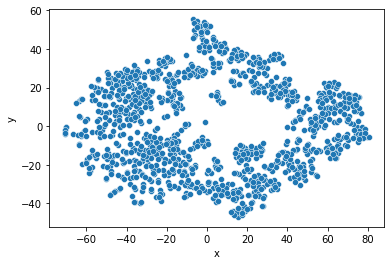

In [11]:
sns.scatterplot(x='x', y='y', data = tsne_pd)

In [13]:
combined_with_tsne = combined_stats.reset_index().merge(tsne_pd, how ='left', left_index=True, right_index=True)
combined_with_tsne#.to_csv("combined_with_tsne.csv", index=False)

,PLAYER_ID,OPP_FGM_LESS5,OPP_FGA_LESS5,OPP_FG_PCT_LESS5,OPP_FGM_5_9,OPP_FGA_5_9,OPP_FG_PCT_5_9,OPP_FGM_10_14,OPP_FGA_10_14,OPP_FG_PCT_10_14,...,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max,x,y
0,101106,1488.0,2757.0,0.539717,410.0,1079.0,0.379981,425.0,1010.0,0.420792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.205942,35.817337
1,101107,4090.0,6790.0,0.602356,759.0,1964.0,0.386456,679.0,1581.0,0.429475,...,52.0,35.0,25.0,28.0,86.0,-106.0,-25.0,23.0,69.553551,4.321854
2,101108,4743.0,7947.0,0.596829,996.0,2474.0,0.402587,769.0,2007.0,0.383159,...,407.0,94.0,8.0,132.0,136.0,277.0,-18.0,21.0,70.186340,11.206311
3,101109,2211.0,3730.0,0.592761,375.0,1015.0,0.369458,337.0,801.0,0.420724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.368191,18.853245
4,101110,788.0,1315.0,0.599240,191.0,449.0,0.425390,136.0,359.0,0.378830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018489,42.207329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,951,651.0,1091.0,0.596700,146.0,317.0,0.460568,82.0,203.0,0.403941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.577608,22.433786
1070,959,126.0,211.0,0.597156,18.0,57.0,0.315789,22.0,49.0,0.448980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.100320,17.018021
1071,965,453.0,810.0,0.559259,86.0,233.0,0.369099,77.0,180.0,0.427778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.923997,45.641922
1072,977,1412.0,2237.0,0.631203,213.0,504.0,0.422619,193.0,464.0,0.415948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.580619,31.116123


### Per 36

Let's see how things shift when we adjust the raw counts to a per-36 minute basis.

In [14]:
combined_per36 = (combined_stats
                  .assign(per36_factor = lambda df: 36.0 / df.MIN,
                          OPP_FGM_LESS5 = lambda df: df.OPP_FGM_LESS5 * df.per36_factor,
                          OPP_FGA_LESS5 = lambda df: df.OPP_FGA_LESS5 * df.per36_factor,
                          OPP_FGM_5_9 = lambda df: df.OPP_FGM_5_9 * df.per36_factor,
                          OPP_FGA_5_9 = lambda df: df.OPP_FGA_5_9 * df.per36_factor,
                          OPP_FGM_10_14 = lambda df: df.OPP_FGM_10_14 * df.per36_factor,
                          OPP_FGA_10_14 = lambda df: df.OPP_FGA_10_14 * df.per36_factor,
                          OPP_FGM_15_19 = lambda df: df.OPP_FGM_15_19 * df.per36_factor,
                          OPP_FGA_15_19 = lambda df: df.OPP_FGA_15_19 * df.per36_factor,
                          OPP_FGM_20_24 = lambda df: df.OPP_FGM_20_24 * df.per36_factor,
                          OPP_FGA_20_24 = lambda df: df.OPP_FGA_20_24 * df.per36_factor,
                          OPP_FGM_25_29 = lambda df: df.OPP_FGM_25_29 * df.per36_factor,
                          OPP_FGA_25_29 = lambda df: df.OPP_FGA_25_29 * df.per36_factor,
                          OPP_FGM_30_34 = lambda df: df.OPP_FGM_30_34 * df.per36_factor,
                          OPP_FGA_30_34 = lambda df: df.OPP_FGA_30_34 * df.per36_factor,
                          OPP_FGM_35_39 = lambda df: df.OPP_FGM_35_39 * df.per36_factor,
                          OPP_FGA_35_39 = lambda df: df.OPP_FGA_35_39 * df.per36_factor,
                          OPP_FGM_40PLUS = lambda df: df.OPP_FGM_40PLUS * df.per36_factor,
                          OPP_FGA_40PLUS = lambda df: df.OPP_FGA_40PLUS * df.per36_factor,
                          OPP_FGM_LESS5_PACE_ADJ = lambda df: df.OPP_FGM_LESS5_PACE_ADJ * df.per36_factor,
                          OPP_FGA_LESS5_PACE_ADJ = lambda df: df.OPP_FGA_LESS5_PACE_ADJ * df.per36_factor,
                          OPP_FGM_5_9_PACE_ADJ = lambda df: df.OPP_FGM_5_9_PACE_ADJ * df.per36_factor,
                          OPP_FGA_5_9_PACE_ADJ = lambda df: df.OPP_FGA_5_9_PACE_ADJ * df.per36_factor,
                          OPP_FGM_10_14_PACE_ADJ = lambda df: df.OPP_FGM_10_14_PACE_ADJ * df.per36_factor,
                          OPP_FGA_10_14_PACE_ADJ = lambda df: df.OPP_FGA_10_14_PACE_ADJ * df.per36_factor,
                          OPP_FGM_15_19_PACE_ADJ = lambda df: df.OPP_FGM_15_19_PACE_ADJ * df.per36_factor,
                          OPP_FGA_15_19_PACE_ADJ = lambda df: df.OPP_FGA_15_19_PACE_ADJ * df.per36_factor,
                          OPP_FGM_20_24_PACE_ADJ = lambda df: df.OPP_FGM_20_24_PACE_ADJ * df.per36_factor,
                          OPP_FGA_20_24_PACE_ADJ = lambda df: df.OPP_FGA_20_24_PACE_ADJ * df.per36_factor,
                          OPP_FGM_25_29_PACE_ADJ = lambda df: df.OPP_FGM_25_29_PACE_ADJ * df.per36_factor,
                          OPP_FGA_25_29_PACE_ADJ = lambda df: df.OPP_FGA_25_29_PACE_ADJ * df.per36_factor,
                          OPP_FGM_30_34_PACE_ADJ = lambda df: df.OPP_FGM_30_34_PACE_ADJ * df.per36_factor,
                          OPP_FGA_30_34_PACE_ADJ = lambda df: df.OPP_FGA_30_34_PACE_ADJ * df.per36_factor,
                          OPP_FGM_35_39_PACE_ADJ = lambda df: df.OPP_FGM_35_39_PACE_ADJ * df.per36_factor,
                          OPP_FGA_35_39_PACE_ADJ = lambda df: df.OPP_FGA_35_39_PACE_ADJ * df.per36_factor,
                          OPP_FGM_40PLUS_PACE_ADJ = lambda df: df.OPP_FGM_40PLUS_PACE_ADJ * df.per36_factor,
                          OPP_FGA_40PLUS_PACE_ADJ = lambda df: df.OPP_FGA_40PLUS_PACE_ADJ * df.per36_factor,
                          OREB = lambda df: df.OREB * df.per36_factor,
                          OREB_CONTEST = lambda df: df.OREB_CONTEST * df.per36_factor,
                          OREB_UNCONTEST = lambda df: df.OREB_UNCONTEST * df.per36_factor,
                          OREB_CHANCES = lambda df: df.OREB_CHANCES * df.per36_factor,
                          OREB_CHANCE_DEFER = lambda df: df.OREB_CHANCE_DEFER * df.per36_factor,
                          DREB_CONTEST = lambda df: df.DREB_CONTEST * df.per36_factor,
                          DREB_UNCONTEST = lambda df: df.DREB_UNCONTEST * df.per36_factor,
                          DREB_CHANCES = lambda df: df.DREB_CHANCES * df.per36_factor,
                          DREB_CHANCE_DEFER = lambda df: df.DREB_CHANCE_DEFER * df.per36_factor,
                          REB = lambda df: df.REB * df.per36_factor,
                          REB_CONTEST = lambda df: df.REB_CONTEST * df.per36_factor,
                          REB_UNCONTEST = lambda df: df.REB_UNCONTEST * df.per36_factor,
                          REB_CHANCES = lambda df: df.REB_CHANCES * df.per36_factor,
                          REB_CHANCE_DEFER = lambda df: df.REB_CHANCE_DEFER * df.per36_factor,
                          AVG_REB_DIST = lambda df: df.AVG_REB_DIST * df.per36_factor,
                          STL = lambda df: df.STL * df.per36_factor,
                          BLK = lambda df: df.BLK * df.per36_factor,
                          DREB = lambda df: df.DREB * df.per36_factor,
                          DEF_RIM_FGM = lambda df: df.DEF_RIM_FGM * df.per36_factor,
                          DEF_RIM_FGA = lambda df: df.DEF_RIM_FGA * df.per36_factor,
                          CONTESTED_SHOTS = lambda df: df.CONTESTED_SHOTS * df.per36_factor,
                          CONTESTED_SHOTS_2PT = lambda df: df.CONTESTED_SHOTS_2PT * df.per36_factor,
                          CONTESTED_SHOTS_3PT = lambda df: df.CONTESTED_SHOTS_3PT * df.per36_factor,
                          DEFLECTIONS = lambda df: df.DEFLECTIONS * df.per36_factor,
                          CHARGES_DRAWN = lambda df: df.CHARGES_DRAWN * df.per36_factor,
                          SCREEN_ASSISTS = lambda df: df.SCREEN_ASSISTS * df.per36_factor,
                          SCREEN_AST_PTS = lambda df: df.SCREEN_AST_PTS * df.per36_factor,
                          OFF_LOOSE_BALLS_RECOVERED = lambda df: df.OFF_LOOSE_BALLS_RECOVERED * df.per36_factor,
                          DEF_LOOSE_BALLS_RECOVERED = lambda df: df.DEF_LOOSE_BALLS_RECOVERED * df.per36_factor,
                          LOOSE_BALLS_RECOVERED = lambda df: df.LOOSE_BALLS_RECOVERED * df.per36_factor,
                          OFF_BOXOUTS = lambda df: df.OFF_BOXOUTS * df.per36_factor,
                          DEF_BOXOUTS = lambda df: df.DEF_BOXOUTS * df.per36_factor,
                          BOX_OUTS = lambda df: df.BOX_OUTS * df.per36_factor,
                          BOX_OUT_PLAYER_TEAM_REBS = lambda df: df.BOX_OUT_PLAYER_TEAM_REBS * df.per36_factor,
                          BOX_OUT_PLAYER_REBS = lambda df: df.BOX_OUT_PLAYER_REBS * df.per36_factor,
                          OPP_FGM_RES_AREA = lambda df: df.OPP_FGM_RES_AREA * df.per36_factor,
                          OPP_FGA_RES_AREA = lambda df: df.OPP_FGA_RES_AREA * df.per36_factor,
                          OPP_FGM_PAINT = lambda df: df.OPP_FGM_PAINT * df.per36_factor,
                          OPP_FGA_PAINT = lambda df: df.OPP_FGA_PAINT * df.per36_factor,
                          OPP_FGM_MID = lambda df: df.OPP_FGM_MID * df.per36_factor,
                          OPP_FGA_MID = lambda df: df.OPP_FGA_MID * df.per36_factor,
                          OPP_FG_PCT_MID = lambda df: df.OPP_FG_PCT_MID * df.per36_factor,
                          OPP_FGM_LEFT_CORNER = lambda df: df.OPP_FGM_LEFT_CORNER * df.per36_factor,
                          OPP_FGA_LEFT_CORNER = lambda df: df.OPP_FGA_LEFT_CORNER * df.per36_factor,
                          OPP_FGM_RIGHT_CORNER = lambda df: df.OPP_FGM_RIGHT_CORNER * df.per36_factor,
                          OPP_FGA_RIGHT_CORNER = lambda df: df.OPP_FGA_RIGHT_CORNER * df.per36_factor,
                          OPP_FGM_ABOVE_BREAK = lambda df: df.OPP_FGM_ABOVE_BREAK * df.per36_factor,
                          OPP_FGA_ABOVE_BREAK = lambda df: df.OPP_FGA_ABOVE_BREAK * df.per36_factor,
                          OPP_FGM_BACKCOURT = lambda df: df.OPP_FGM_BACKCOURT * df.per36_factor,
                          OPP_FGA_BACKCOURT = lambda df: df.OPP_FGA_BACKCOURT * df.per36_factor,
                          OPP_FGM_RES_AREA_PACE_ADJ = lambda df: df.OPP_FGM_RES_AREA_PACE_ADJ * df.per36_factor,
                          OPP_FGA_RES_AREA_PACE_ADJ = lambda df: df.OPP_FGA_RES_AREA_PACE_ADJ * df.per36_factor,
                          OPP_FGM_PAINT_PACE_ADJ = lambda df: df.OPP_FGM_PAINT_PACE_ADJ * df.per36_factor,
                          OPP_FGA_PAINT_PACE_ADJ = lambda df: df.OPP_FGA_PAINT_PACE_ADJ * df.per36_factor,
                          OPP_FGM_MID_PACE_ADJ = lambda df: df.OPP_FGM_MID_PACE_ADJ * df.per36_factor,
                          OPP_FGA_MID_PACE_ADJ = lambda df: df.OPP_FGA_MID_PACE_ADJ * df.per36_factor,
                          OPP_FGM_LEFT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_LEFT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGA_LEFT_CORNER_PACE_ADJ = lambda df: df.OPP_FGA_LEFT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGM_RIGHT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_RIGHT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGA_RIGHT_CORNER_PACE_ADJ = lambda df: df.OPP_FGA_RIGHT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGM_ABOVE_BREAK_PACE_ADJ = lambda df: df.OPP_FGM_ABOVE_BREAK_PACE_ADJ * df.per36_factor,
                          OPP_FGA_ABOVE_BREAK_PACE_ADJ = lambda df: df.OPP_FGA_ABOVE_BREAK_PACE_ADJ * df.per36_factor,
                          OPP_FGM_BACKCOURT_PACE_ADJ = lambda df: df.OPP_FGM_BACKCOURT_PACE_ADJ * df.per36_factor,
                          OPP_FGA_BACKCOURT_PACE_ADJ = lambda df: df.OPP_FGA_BACKCOURT_PACE_ADJ * df.per36_factor,
                          ast_sum = lambda df: df.ast_sum * df.per36_factor,
                          stl_sum = lambda df: df.stl_sum * df.per36_factor,
                          blk_sum = lambda df: df.blk_sum * df.per36_factor,
                          tov_sum = lambda df: df.tov_sum * df.per36_factor,
                          pf_sum = lambda df: df.pf_sum * df.per36_factor,
                          plusminus_sum = lambda df: df.plusminus_sum * df.per36_factor
                         ))

combined_per36.head(5)

,OPP_FGM_LESS5,OPP_FGA_LESS5,OPP_FG_PCT_LESS5,OPP_FGM_5_9,OPP_FGA_5_9,OPP_FG_PCT_5_9,OPP_FGM_10_14,OPP_FGA_10_14,OPP_FG_PCT_10_14,OPP_FGM_15_19,...,minutes_sum,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max,per36_factor
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
101106,10.438646,19.340959,0.539717,2.876240,7.569421,0.379981,2.981468,7.085371,0.420792,4.714227,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.007015
101107,13.180085,21.880874,0.602356,2.445889,6.329019,0.386456,2.188087,5.094796,0.429475,3.547989,...,966.0,0.167571,0.112788,0.080563,0.090230,0.277136,-0.341587,-25.0,23.0,0.003223
101108,12.975758,21.741166,0.596829,2.724827,6.768295,0.402587,2.103807,5.490691,0.383159,2.845201,...,1934.0,1.113458,0.257162,0.021886,0.361122,0.372065,0.757808,-18.0,21.0,0.002736
101109,12.823999,21.634337,0.592761,2.175034,5.887092,0.369458,1.954630,4.645872,0.420724,2.905845,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.005800
101110,11.444709,19.098721,0.599240,2.774035,6.521160,0.425390,1.975229,5.214023,0.378830,3.761649,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.014524


In [ ]:
combined_per36 = (combined_stats
                .assign(per36_factor = lambda df: 36.0 / df.MIN,
                        OPP_FGM_LESS5 = lambda df: df.OPP_FGM_LESS5 * df.per36_factor,
                        OPP_FGA_LESS5 = lambda df: df.OPP_FGA_LESS5 * df.per36_factor,
                        OPP_FGM_5_9 = lambda df: df.OPP_FGM_5_9 * df.per36_factor,
                        ...
                        tov_sum = lambda df: df.tov_sum * df.per36_factor,
                        pf_sum = lambda df: df.pf_sum * df.per36_factor,
                        plusminus_sum = lambda df: df.plusminus_sum * df.per36_factor
                        ))

combined_per36.head(5)

,OPP_FGM_LESS5,OPP_FGA_LESS5,OPP_FG_PCT_LESS5,OPP_FGM_5_9,OPP_FGA_5_9,OPP_FG_PCT_5_9,OPP_FGM_10_14,OPP_FGA_10_14,OPP_FG_PCT_10_14,OPP_FGM_15_19,...,minutes_sum,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max,per36_factor
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
101106,10.438646,19.340959,0.539717,2.876240,7.569421,0.379981,2.981468,7.085371,0.420792,4.714227,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.007015
101107,13.180085,21.880874,0.602356,2.445889,6.329019,0.386456,2.188087,5.094796,0.429475,3.547989,...,966.0,0.167571,0.112788,0.080563,0.090230,0.277136,-0.341587,-25.0,23.0,0.003223
101108,12.975758,21.741166,0.596829,2.724827,6.768295,0.402587,2.103807,5.490691,0.383159,2.845201,...,1934.0,1.113458,0.257162,0.021886,0.361122,0.372065,0.757808,-18.0,21.0,0.002736
101109,12.823999,21.634337,0.592761,2.175034,5.887092,0.369458,1.954630,4.645872,0.420724,2.905845,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.005800
101110,11.444709,19.098721,0.599240,2.774035,6.521160,0.425390,1.975229,5.214023,0.378830,3.761649,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.014524


In [15]:
scaled_per36 = preprocessing.scale(combined_per36)
pca_per36 = PCA(n_components=50)
pca_scaled_per36 = pca_per36.fit_transform(scaled_per36)
pca_per36.explained_variance_ratio_

array([0.11162024, 0.0913862 , 0.07683562, 0.06455147, 0.04624288,
       0.04416076, 0.03746645, 0.03289114, 0.02954936, 0.02657063,
       0.0253791 , 0.02250448, 0.02117909, 0.01984407, 0.01869613,
       0.01844544, 0.01724768, 0.01513936, 0.01463429, 0.01358315,
       0.01285663, 0.01219152, 0.01133477, 0.01106436, 0.01024257,
       0.00944162, 0.00917732, 0.00864021, 0.00841334, 0.00803031,
       0.00776567, 0.00755214, 0.00695682, 0.00634682, 0.00624979,
       0.00584164, 0.00561142, 0.00542259, 0.00511201, 0.00492372,
       0.00466752, 0.00441113, 0.00387919, 0.00376466, 0.00372141,
       0.00355334, 0.00339844, 0.00334797, 0.00320128, 0.00305668])

In [16]:
current_season_player_id_ints = list(overall_stats_raw[overall_stats_raw['Season'] == '2019-20']['idPlayer'].drop_duplicates())
current_season_player_ids = [str(i) for i in current_season_player_id_ints]
current_season_filter = combined_stats.index.isin(current_season_player_ids)
pca_scaled_per36[current_season_filter].shape

(513, 50)

In [17]:
clustering = AgglomerativeClustering(n_clusters=4).fit(pca_scaled_per36[current_season_filter])

In [20]:
#pd.Series(clustering.labels_).value_counts()
pca_with_cluster_col = (pd.DataFrame(pca_scaled_per36[current_season_filter]).assign(label = clustering.labels_))
pca_with_clusters = pd.get_dummies(pca_with_cluster_col, columns = ['label'])
pca_with_clusters

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,label_0,label_1,label_2,label_3
0,-1.732806,-4.432393,-3.312895,-2.078466,0.712733,2.686622,-1.374033,-0.083841,0.275253,0.921103,...,-0.370207,0.454105,-0.113807,-0.037804,0.486972,-0.237467,0,0,0,1
1,-1.025242,-2.671325,-5.285929,-0.807115,2.395147,2.581663,-2.059473,-0.316649,-0.432962,0.687496,...,0.407605,-0.034065,-0.353886,0.164799,0.238095,-0.270884,0,0,0,1
2,-1.433728,-5.447619,0.839847,-2.870298,0.080352,1.340002,-0.572995,0.094993,0.691592,0.538934,...,-0.360076,0.293206,-0.089528,-0.093877,0.403012,-0.029558,0,0,0,1
3,2.315475,-0.871184,-2.459420,0.082097,2.154959,0.856779,-0.445195,-0.378807,0.350076,1.184911,...,-0.501163,0.398344,-0.352765,-0.136718,-0.148263,-0.240686,0,0,0,1
4,-2.339053,-5.118803,-1.873009,-2.378879,0.742302,1.911395,-0.496739,0.271957,0.382864,1.516172,...,0.560427,0.187728,0.879009,-0.194380,-0.109165,-0.796212,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.763735,-2.074575,-4.433156,-1.371267,2.356409,3.082969,-0.869138,-0.084385,-0.147795,0.652731,...,0.006830,-0.436820,-0.457668,-0.247468,0.387771,-0.341275,0,0,0,1
509,2.439752,-1.495681,2.066335,-0.951327,0.367650,-0.055941,2.286971,1.211642,-0.370335,0.105885,...,-2.009694,0.070675,-0.584734,0.564583,-1.323359,-0.060387,0,1,0,0
510,-2.893256,-8.115828,0.573125,-3.273391,-0.844140,1.910436,-1.981592,0.928966,0.216057,-0.275500,...,0.287277,-0.417237,1.077716,1.003527,-0.863598,-0.012456,0,0,0,1
511,0.437726,-3.252705,-3.470169,-0.026308,2.818107,0.884429,-0.955020,0.274241,0.389754,0.305190,...,0.140582,0.018166,-0.117148,0.276441,0.462815,-0.046048,0,0,0,1


In [49]:
# tsne_per36 = TSNE(n_components=2, perplexity=15, n_iter = 40000).fit_transform(pca_scaled_per36[current_season_filter])
tsne_per36 = TSNE(n_components=2, perplexity=15, n_iter = 50000).fit_transform(pca_with_clusters)
tsne_per36_df = pd.DataFrame(tsne_per36, columns = ['x', 'y'])

<AxesSubplot:xlabel='x', ylabel='y'>

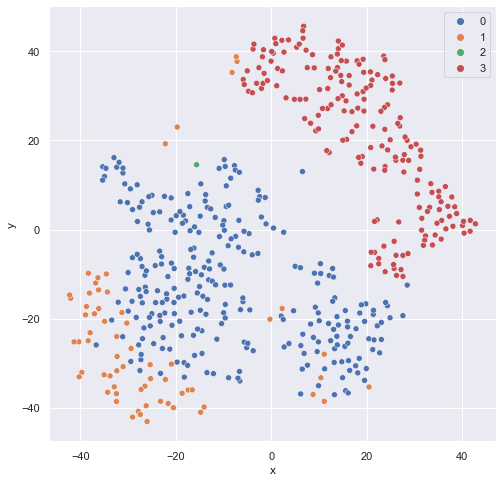

In [50]:
sns.set(rc={"figure.figsize": (8,8)})
sns.scatterplot(x='x', y='y', hue = clustering.labels_, palette = 'deep', data = tsne_per36_df)

In [35]:
combined_with_per36_tsne = (combined_stats[current_season_filter]
                            .reset_index()
                            .merge(tsne_per36_df, 
                                   how ='left', 
                                   left_index=True, 
                                   right_index=True)
                            .assign(cluster_label = clustering.labels_))
combined_with_per36_tsne.to_csv("combined_with_per36_tsne_with_additional_seasons.csv", index=False)

Nearest Neighbors

In [36]:
neigh = NearestNeighbors()
neigh.fit(pca_scaled_per36[current_season_filter])
neigh_graph = neigh.kneighbors_graph(pca_scaled_per36[current_season_filter]).toarray()
distances, indices = neigh.kneighbors(pca_scaled_per36[current_season_filter])
indices[:10]

array([[  0, 395, 394, 325, 429],
       [  1, 360, 381, 385, 357],
       [  2, 430, 440, 421, 436],
       [  3, 352, 457, 400, 398],
       [  4,   0, 336, 444, 366],
       [  5, 441, 403, 415, 423],
       [  6,  14, 448,  26,  44],
       [  7, 500,  19, 471, 342],
       [  8, 133,  46,  80,  99],
       [  9,  15, 449, 501, 129]])

In [37]:
mm_scaler = preprocessing.MinMaxScaler()

zipped_sample = zip(indices, distances, clustering.labels_)
player_comp_list = []

for z in zipped_sample:
    i, d, clus = z
    root_player_id = int(combined_stats[current_season_filter].iloc[i[0]].name)
    try:
        root_player_name = overall_stats_raw[overall_stats_raw['idPlayer'] == root_player_id].iloc[0]['Player']
        for player in range(1, len(i)):
            comp_player_id = int(combined_stats[current_season_filter].iloc[i[player]].name)
            player_name = overall_stats_raw[overall_stats_raw['idPlayer'] == comp_player_id].iloc[0]['Player']
            new_row = [root_player_id, root_player_name, clus, player, comp_player_id, player_name, d[player]]
            player_comp_list.append(new_row)
    except:
        print("could not find player match for player id {}".format(root_player_id))
        
player_comp_df = (pd.DataFrame(player_comp_list, 
                               columns = ['player_id', 'player_name', 'player_cluster', 'rank', 'neighbor_player_id', 'neighbor_player_name', 'neighbor_player_distance'])
                  .assign(dist_prox = lambda df: mm_scaler.fit_transform(df[['neighbor_player_distance']]),
                          pct_match = lambda df: 1 - df.dist_prox))

In [71]:
player_comp_df.shape

(2052, 9)

In [47]:
player_comp_df.sort_values('pct_match', ascending=False).query("player_cluster == 3").query("rank == 1").head(20)

,player_id,player_name,player_cluster,rank,neighbor_player_id,neighbor_player_name,neighbor_player_distance,dist_prox,pct_match
1428,201609,Goran Dragic,3,1,202340,Avery Bradley,2.056398,0.000000,1.000000
1528,202340,Avery Bradley,3,1,201609,Goran Dragic,2.056398,0.000000,1.000000
1904,203918,Rodney Hood,3,1,201961,Wayne Ellington,2.200477,0.002289,0.997711
1472,201961,Wayne Ellington,3,1,203918,Rodney Hood,2.200477,0.002289,0.997711
1388,201571,D.J. Augustin,3,1,200755,JJ Redick,2.272465,0.003433,0.996567
1304,200755,JJ Redick,3,1,201571,D.J. Augustin,2.272465,0.003433,0.996567
1544,202681,Kyrie Irving,3,1,202704,Reggie Jackson,2.310372,0.004035,0.995965
1600,202704,Reggie Jackson,3,1,202681,Kyrie Irving,2.310372,0.004035,0.995965
1384,201569,Eric Gordon,3,1,201571,D.J. Augustin,2.330423,0.004353,0.995647
1756,203468,CJ McCollum,3,1,203081,Damian Lillard,2.386667,0.005247,0.994753


In [44]:
player_comp_df.sort_values('pct_match', ascending=False).query("player_cluster == 1").head(20)

,player_id,player_name,player_cluster,rank,neighbor_player_id,neighbor_player_name,neighbor_player_distance,dist_prox,pct_match
36,1626147,Justin Anderson,1,1,1626159,Justise Winslow,5.553064,0.055550,0.944450
37,1626147,Justin Anderson,1,2,203490,Otto Porter Jr.,5.680884,0.057580,0.942420
38,1626147,Justin Anderson,1,3,204025,Tim Frazier,5.724172,0.058268,0.941732
516,1628412,Frank Mason,1,1,1626147,Justin Anderson,5.874561,0.060657,0.939343
39,1626147,Justin Anderson,1,4,1628412,Frank Mason,5.874561,0.060657,0.939343
517,1628412,Frank Mason,1,2,204025,Tim Frazier,6.243333,0.066516,0.933484
518,1628412,Frank Mason,1,3,1628443,Kadeem Allen,6.288655,0.067236,0.932764
519,1628412,Frank Mason,1,4,1628372,Dennis Smith Jr.,6.389918,0.068844,0.931156
784,1629017,Khyri Thomas,1,1,1628443,Kadeem Allen,6.909035,0.077091,0.922909
1872,203705,Josh Magette,1,1,1628412,Frank Mason,7.042022,0.079204,0.920796


In [46]:
player_comp_df.sort_values('pct_match', ascending=False).query("player_cluster == 0").query("rank == 1").head(20)

,player_id,player_name,player_cluster,rank,neighbor_player_id,neighbor_player_name,neighbor_player_distance,dist_prox,pct_match
204,1627742,Brandon Ingram,0,1,1628366,Lonzo Ball,2.803512,0.011869,0.988131
368,1628366,Lonzo Ball,0,1,1627742,Brandon Ingram,2.803512,0.011869,0.988131
380,1628369,Jayson Tatum,0,1,1627759,Jaylen Brown,2.913144,0.013611,0.986389
244,1627759,Jaylen Brown,0,1,1628369,Jayson Tatum,2.913144,0.013611,0.986389
492,1628404,Josh Hart,0,1,1627742,Brandon Ingram,2.953528,0.014252,0.985748
248,1627761,DeAndre' Bembry,0,1,1627739,Kris Dunn,3.062817,0.015988,0.984012
192,1627739,Kris Dunn,0,1,1627761,DeAndre' Bembry,3.062817,0.015988,0.984012
44,1626153,Delon Wright,0,1,1626162,Kelly Oubre Jr.,3.097539,0.016540,0.983460
68,1626162,Kelly Oubre Jr.,0,1,1626153,Delon Wright,3.097539,0.016540,0.983460
700,1628989,Kevin Huerter,0,1,1627742,Brandon Ingram,3.122144,0.016931,0.983069


In [132]:
player_comp_df.to_csv('player_comparisons_with_previous_seasons.csv', index=False)

In [51]:
player_comp_df[player_comp_df['player_name'] == 'LeBron James'][['player_name', 'player_cluster', 'rank', 'neighbor_player_name', 'pct_match']]

,player_name,player_cluster,rank,neighbor_player_name,pct_match
2024,LeBron James,3,1,Tobias Harris,0.986453
2025,LeBron James,3,2,P.J. Tucker,0.982009
2026,LeBron James,3,3,Jae Crowder,0.980892
2027,LeBron James,3,4,Khris Middleton,0.978541


In [68]:
player_comp_df[player_comp_df['player_name'] == 'Rudy Gobert'][['player_name', 'player_cluster', 'rank', 'neighbor_player_name', 'pct_match']]

,player_name,player_cluster,rank,neighbor_player_name,pct_match
1808,Rudy Gobert,3,1,Jonas Valanciunas,0.959139
1809,Rudy Gobert,3,2,Dwight Howard,0.957870
1810,Rudy Gobert,3,3,Hassan Whiteside,0.955600
1811,Rudy Gobert,3,4,Bismack Biyombo,0.953582


In [67]:
# player_comp_df[player_comp_df['player_name'] == 'Draymond Green']
# player_comp_df[player_comp_df['player_name'] == 'Goga Bitadze']
player_comp_df.query("rank == 1").sort_values('pct_match').head(80).tail(20)

player_comp_df[player_comp_df['player_name'] == 'Mo Bamba'][['player_name', 'player_cluster', 'rank', 'neighbor_player_name', 'pct_match']]



,player_name,player_cluster,rank,neighbor_player_name,pct_match
620,Mo Bamba,0,1,Ivica Zubac,0.951529
621,Mo Bamba,0,2,Mitchell Robinson,0.951293
622,Mo Bamba,0,3,Jakob Poeltl,0.933874
623,Mo Bamba,0,4,JaVale McGee,0.933155


In [199]:
player_comp_df[player_comp_df['player_cluster'] == 1][['player_name']].drop_duplicates()

,player_name
0,Marvin Williams
4,Chris Paul
8,Ian Mahinmi
12,CJ Miles
16,Ersan Ilyasova
...,...
2028,Carmelo Anthony
2032,Kyle Korver
2040,Dwight Howard
2044,Andre Iguodala
